In [125]:
from dataclasses import asdict, dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Generator, Optional
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from itertools import product
from scipy.ndimage import gaussian_filter1d

# constants
INPUT_FILE = "data/full_cycle_with_idle.txt"
ACCELEROMETER_SAMPLE_RATE_HZ = 104
Z_SCORE_THRESHOLD = 3
MILLIS_OFFSET = 3702

# function to read text files, parse into dataclass
@dataclass
class AccelerometerReading:
  timeStampMs: int
  x: float
  y: float
  z: float

# sample reading: 19:09:28:874 -> 3702 -> (0.004, 0.460, 0.003)
def parseReading(reading: str) -> Optional[AccelerometerReading]:
  dataParts = reading.split(" -> ")
  if len(dataParts) != 2:
    print(f'Expected 2 parts of data, received {len(dataParts)}')
    return None

  timeStr = dataParts[0]
  readingStr = dataParts[1]

  # parse time value
  timeValue = None
  try:
    timeValue = int(timeStr) - MILLIS_OFFSET # offset first reading to be at t=0
  except:
    print(f'failed to parse time component of {reading}: {timeStr}')
    return None

  # remove parenthesis from readingStr
  readingStr = readingStr.removeprefix("(")
  readingStr = readingStr.removesuffix(")")
  readingVals = readingStr.strip().split(", ")
  if len(readingVals) != 3:
    print(f'failed to read string: {reading}')
    return None
  
  x, y, z = 0.0, 0.0, 0.0

  try:
    x = float(readingVals[0].strip())
    y = float(readingVals[1].strip())
    z = float(readingVals[2].strip())
  except:
    print(f'failed to read string: {reading}')
    return None

  return AccelerometerReading(timeValue, x, y, z)

def readFileLineGenerator(path: Path) -> Generator[str, None, None]:
  with open(path, "r") as file:
    for line in file:
      yield line.strip()

In [126]:
# read input files into generator objects, parse them
rawReadings = readFileLineGenerator(INPUT_FILE)
parsedReadings = (parseReading(readingString) for readingString in rawReadings)

In [127]:
# convert to dictionary for transformation into pandas dataframe, excluding parsing failures
readingsDict = (asdict(reading) for reading in parsedReadings if reading is not None)

readingsDf = pd.DataFrame(readingsDict)
readingsDf.describe()

,timeStampMs,x,y,z
count,8.725480e+05,872548.000000,872548.000000,872548.000000
mean,4.183147e+06,0.013524,-0.973123,0.019159
std,2.415225e+06,0.011087,0.303917,0.017070
min,0.000000e+00,0.000000,-1.161000,0.000000
25%,2.091518e+06,0.009000,-1.022000,0.011000
50%,4.183038e+06,0.012000,-1.019000,0.015000
75%,6.274750e+06,0.016000,-1.017000,0.023000
max,8.366646e+06,0.285000,0.999000,0.443000


In [128]:
# preprocess for preliminary plotting
readingsDf = readingsDf.sort_values('timeStampMs') # keep time-series sorted

# throw out the first 2 readings, sensor is not yet normalized
readingsDf = readingsDf[readingsDf.index > 1]

# label data regions
idle_region_timestamps = [[0, 163200], [3993208, 4284609], [7644302, 8366646]]
washing_machine_final_timestamp = 3900108
dryer_final_timestamp = 7600227

readingsDf['state'] = "IDLE"
readingsDf.loc[(readingsDf['timeStampMs'] > idle_region_timestamps[0][1]) & (readingsDf['timeStampMs'] < idle_region_timestamps[1][0]), 'state'] = "WASHING"
readingsDf.loc[(readingsDf['timeStampMs'] > idle_region_timestamps[1][1]) & (readingsDf['timeStampMs'] < idle_region_timestamps[2][0]), 'state'] = "DRYING"

# calculate magnitude
readingsDf['magnitude'] = np.round(np.sqrt(readingsDf['x']**2 + readingsDf['y']**2 + readingsDf['z'] ** 2), 3) # calculate magnitude of acceleration vector

In [129]:
def plot(y_series, x_series, title, xlabel, ylabel, with_regions=True):
  plt.figure(figsize=(30, 6))
  plt.plot(x_series, y_series)

  # highlight regions based on state
  if with_regions:
    plt.axvspan(idle_region_timestamps[0][1], idle_region_timestamps[1][0], color='blue', alpha=0.3, label="Washing")
    plt.axvspan(idle_region_timestamps[1][1], idle_region_timestamps[2][0], color='red', alpha=0.3, label="Washing")
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.show()

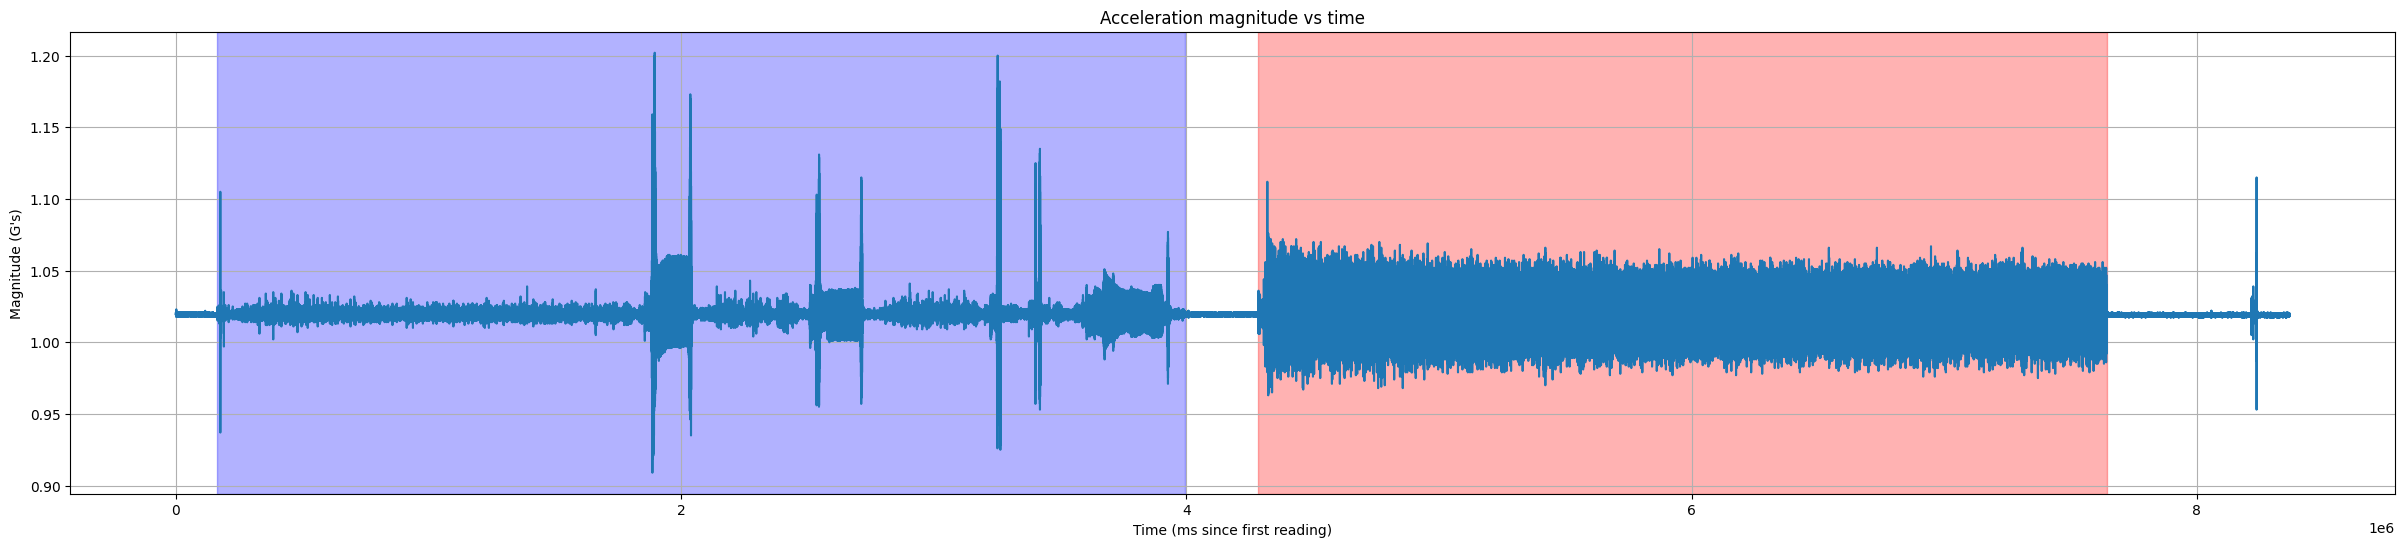

In [130]:
plot(readingsDf['magnitude'], readingsDf['timeStampMs'], "Acceleration magnitude vs time", "Time (ms since first reading)", "Magnitude (G\'s)")

In [131]:
# break out each individual state for analysis (idle is not contiguous, so it's in 3 tranches)
idle_period_1 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] <= idle_region_timestamps[0][1])]
idle_period_2 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] >= idle_region_timestamps[1][0]) & (readingsDf['timeStampMs'] <= idle_region_timestamps[1][1])]
idle_period_3 = readingsDf[(readingsDf['state'] == "IDLE") & (readingsDf['timeStampMs'] >= idle_region_timestamps[2][0])]
washing = readingsDf[readingsDf['state'] == "WASHING"]
drying = readingsDf[readingsDf['state'] == "DRYING"]

In [132]:
all_idle_df = readingsDf[readingsDf['state'] == "IDLE"]
all_idle_df.describe()

,timeStampMs,x,y,z,magnitude
count,1.227380e+05,122738.000000,122738.000000,122738.000000,122738.000000
mean,5.949217e+06,0.011974,-1.019010,0.015165,1.019243
std,2.865209e+06,0.003010,0.021417,0.001832,0.000965
min,1.900000e+01,0.000000,-1.093000,0.000000,0.953000
25%,4.124222e+06,0.011000,-1.020000,0.015000,1.019000
50%,7.778132e+06,0.012000,-1.019000,0.015000,1.019000
75%,8.072388e+06,0.012000,-1.019000,0.015000,1.020000
max,8.366646e+06,0.273000,0.999000,0.271000,1.115000


In [133]:
idle_spread = all_idle_df['magnitude'].max() - all_idle_df['magnitude'].min()
idle_spread

np.float64(0.16200000000000003)

Among the idle readings, there is very little variability. 

The spread of the magnitude (max less min) is 0.162G.
The standard deviation on the magnitude is 0.000965G.

It stands to reason, anything over 1.019 + 0.16 -> 1.179 can be classified as active.

The only question is the period of that activity. Over how long a time period should activity be polled?

In [134]:
washing.describe()

,timeStampMs,x,y,z,magnitude
count,3.994530e+05,399453.000000,399453.000000,399453.000000,399453.000000
mean,2.078202e+06,0.013955,-0.992112,0.019154,1.019949
std,1.105630e+06,0.013713,0.234926,0.020635,0.008144
min,1.632040e+05,0.000000,-1.161000,0.000000,0.909000
25%,1.120701e+06,0.010000,-1.021000,0.011000,1.018000
50%,2.078202e+06,0.012000,-1.020000,0.015000,1.020000
75%,3.035702e+06,0.015000,-1.018000,0.021000,1.021000
max,3.993199e+06,0.285000,0.999000,0.443000,1.202000


In [135]:
drying.describe()

,timeStampMs,x,y,z,magnitude
count,3.503550e+05,350355.000000,350355.000000,350355.000000,350355.000000
mean,5.964401e+06,0.013575,-0.935406,0.020565,1.019789
std,9.698718e+05,0.009355,0.405413,0.015214,0.011557
min,4.284618e+06,0.000000,-1.081000,0.000000,0.963000
25%,5.124450e+06,0.006000,-1.027000,0.008000,1.012000
50%,5.964377e+06,0.012000,-1.019000,0.018000,1.020000
75%,6.804334e+06,0.020000,-1.012000,0.030000,1.027000
max,7.644292e+06,0.223000,0.999000,0.209000,1.112000


# Binary Classification
The below code was arrived at after much trial and error, including the use of frequency analysis.

Keeping in mind that the classifier will be running on embedded hardware, this seemed the most practical and effective solution.

The below code is a grid search for a local optimal solution between the size of the rolling window of observations and the proportion of those observations which are "active" for the overall window to be considered a period of activity.

The thresholds for an individual observation's magnitude to be considered "active" are defined based on hand-labeled "idle" data; observations in excess of the 99th percentile of idle observations are considered active. Observations less than the first percentile are also considered active, since the nature of the accelerometer data includes a reaction of roughly equal magnitude to the initial impulse - the machine accelerates, decelerates, and then accelerates back to its original position, like a pendulum.

In [136]:
data = readingsDf

# data['actual_state'] = np.where(data['state'] != "IDLE", "ACTIVE", "IDLE")

# lookback_periods = np.arange(1, 1024, 100)
# proportions = np.arange(0.01, .99, .05)

# upper_threshold = data[data["actual_state"] == "IDLE"]['magnitude'].quantile(.99)
# lower_threshold = data[data['actual_state'] == "IDLE"]['magnitude'].quantile(0.01)

# data['above_upper'] = data['magnitude'] > upper_threshold
# data['below_lower'] = data['magnitude'] < lower_threshold

# best_f1 = 0
# best_conf_matrix = None
# best_report = None
# best_lookback = None
# best_proportion = None

# prod = list(product(lookback_periods, proportions))

# iteration = 1
# num_iterations = len(prod)
# for lookback_period, proportion_active in prod:
#   print(f"Iteration: {iteration} of {num_iterations}, {iteration / num_iterations * 100:.2f}%")
#   iteration += 1
#   rolling_above_upper = data['above_upper'].rolling(window=lookback_period).mean() >= proportion_active
#   rolling_below_lower = data['below_lower'].rolling(window=lookback_period).mean() >= proportion_active

#   data['predicted_state'] = np.where(rolling_above_upper | rolling_below_lower, "ACTIVE", "IDLE")
#   data.fillna({'predicted_state': "IDLE"}, inplace=True)

#   labels = ['IDLE', 'ACTIVE']

#   conf_matrix = confusion_matrix(data['actual_state'], data['predicted_state'], labels=labels)
#   report = classification_report(data['actual_state'], data['predicted_state'], labels=labels)
#   f1 = f1_score(data['actual_state'], data['predicted_state'], labels=labels, pos_label="ACTIVE")

#   if f1 > best_f1:
#     best_f1 = f1
#     best_conf_matrix = conf_matrix
#     best_report = report
#     best_lookback = lookback_period
#     best_proportion = proportion_active

# print("Best Confusion matrix:")
# print(best_conf_matrix)

# print("\n")
# print("Best Classification Report:")
# print(best_report)


In [137]:
# best_lookback

In [138]:
# best_proportion

# Final Results
A rolling window, where magnitudes are regarded as "active" when in excess of an upper threshold (99% quantile of idle) or below a lower threshold (1% quantile of idle), and idle otherwise.
When a critical proportion of observations are "active" in a given window, the latest observation in the window is considered "active" overall, meaning the machine(s) are running.

The local optimal rolling window size is 1001, and the local optimal proportion is 6%.

The 99% quantile is 1.020, and the 1% quantile is 1.018.

In [139]:
readingsDf.head()

,timeStampMs,x,y,z,state,magnitude
2,19,0.013,-1.020,0.009,IDLE,1.020
3,29,0.013,-1.020,0.009,IDLE,1.020
4,38,0.013,-1.021,0.010,IDLE,1.021
5,48,0.012,-1.021,0.010,IDLE,1.021
6,57,0.012,-1.020,0.010,IDLE,1.020


# Revised approach
Steady state (idle) should be 1.0. Readings should be normalized to that value.

  - Find the axis with the greatest absolute acceleration, identify that as the "gravity" axis.
  - Zero the axes such that, assuming the Y axis is gravity, an idle reading is "(0.000, -1.000, 0.000)"

Readings above 1.0 should be acceleration.

Readings below 1.0 should be deceleration.

State should be identifiable by these accelerations, decelerations relative to 1.000 (stasis).

Then hysteresis can be employed to avoid the worst case scenario: active -> inactive transition when still active. Want to minimize (0) the false negative rate.

In [140]:
# take copy of data to preserve
readings = readingsDf[['timeStampMs', 'x', 'y', 'z', 'state']].copy()
readings['actual_state'] = np.where(readings['state'] != "IDLE", "ACTIVE", "IDLE")
readings = readings.drop('state', axis=1)

# sample the idle data, find idle benchmarks
idleReadings = readings[readings['actual_state'] == "IDLE"]
x_mean = idleReadings['x'].median()
y_mean = idleReadings['y'].median()
z_mean = idleReadings['z'].median()

print(f"({x_mean}, {y_mean}, {z_mean})")

# Y is "gravity axis"
# adjust x, z columns to zero
readings['x_adjusted'] = round(readings['x'] - x_mean, 3)
readings['z_adjusted'] = round(readings['z'] - z_mean, 3)

# adjust y (gravity) column to -1.000
readings['y_adjusted'] = round(readings['y'] - (y_mean - -1.0), 3)

# calculate magnitude based off adjusted columns
readings['magnitude_adjusted'] = round(np.sqrt(readings['x_adjusted'] ** 2 + readings['y_adjusted'] ** 2 + readings['z_adjusted'] ** 2), 3)
readings['magnitude_delta'] = np.abs(readings['magnitude_adjusted'] - 1.000)

readings.head()

(0.012, -1.019, 0.015)


,timeStampMs,x,y,z,actual_state,x_adjusted,z_adjusted,y_adjusted,magnitude_adjusted,magnitude_delta
2,19,0.013,-1.020,0.009,IDLE,0.001,-0.006,-1.001,1.001,0.001
3,29,0.013,-1.020,0.009,IDLE,0.001,-0.006,-1.001,1.001,0.001
4,38,0.013,-1.021,0.010,IDLE,0.001,-0.005,-1.002,1.002,0.002
5,48,0.012,-1.021,0.010,IDLE,0.000,-0.005,-1.002,1.002,0.002
6,57,0.012,-1.020,0.010,IDLE,0.000,-0.005,-1.001,1.001,0.001


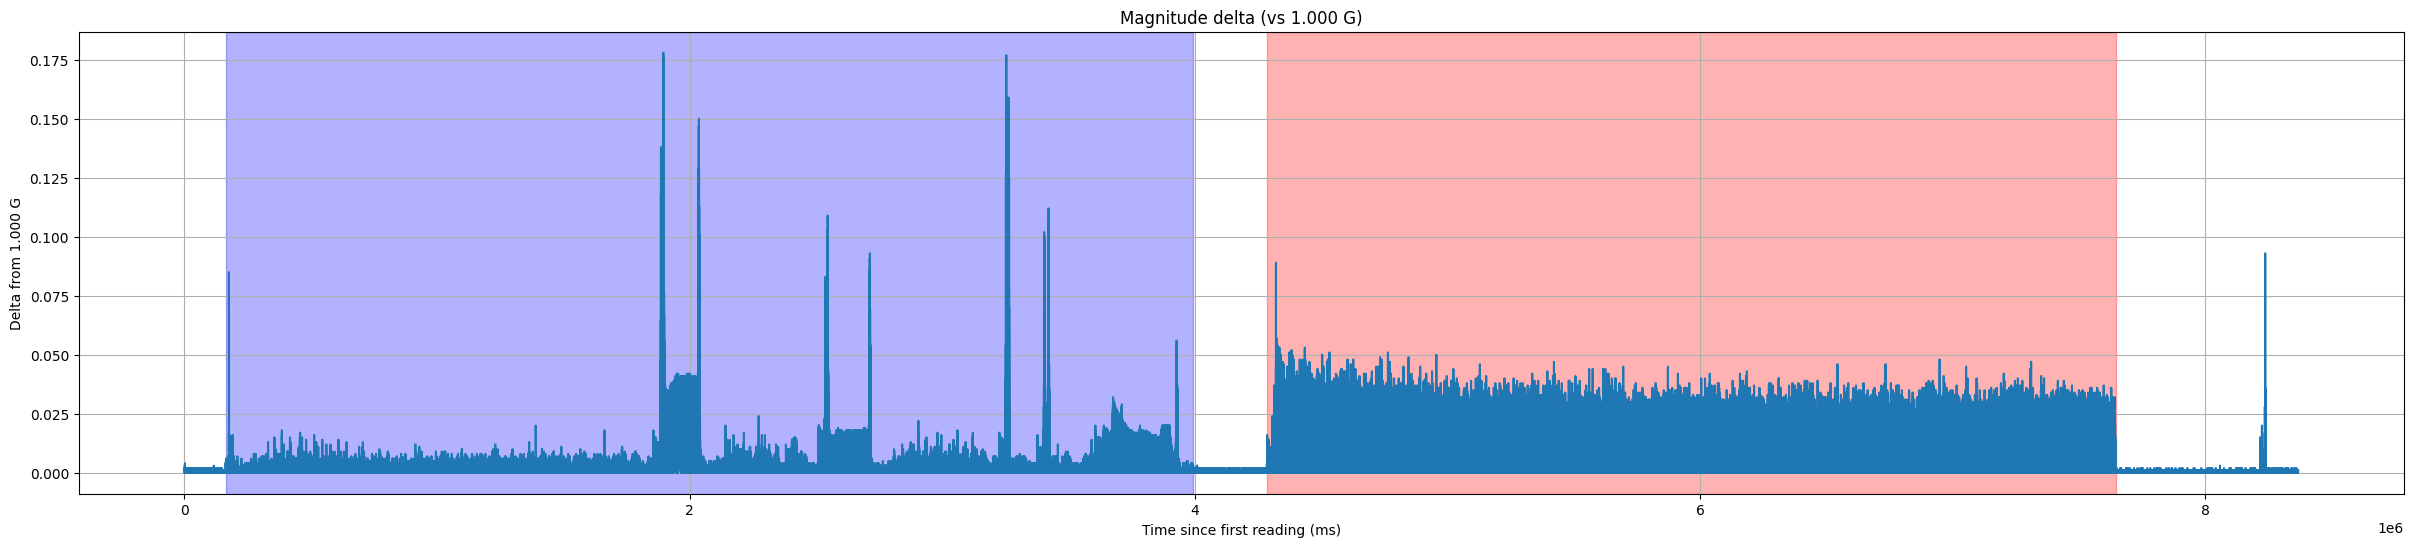

In [141]:
# plot magnitude delta
plot(readings['magnitude_delta'], readings['timeStampMs'], "Magnitude delta (vs 1.000 G)", "Time since first reading (ms)", "Delta from 1.000 G", True)

In [142]:
idle_all = readings[readings['actual_state'] == "IDLE"]

In [143]:
idle_all.describe()

,timeStampMs,x,y,z,x_adjusted,z_adjusted,y_adjusted,magnitude_adjusted,magnitude_delta
count,1.227380e+05,122738.000000,122738.000000,122738.000000,122738.000000,122738.000000,122738.000000,122738.000000,122738.000000
mean,5.949217e+06,0.011974,-1.019010,0.015165,-0.000026,0.000165,-1.000010,1.000244,0.000439
std,2.865209e+06,0.003010,0.021417,0.001832,0.003010,0.001832,0.021417,0.000907,0.000831
min,1.900000e+01,0.000000,-1.093000,0.000000,-0.012000,-0.015000,-1.074000,0.967000,0.000000
25%,4.124222e+06,0.011000,-1.020000,0.015000,-0.001000,0.000000,-1.001000,1.000000,0.000000
50%,7.778132e+06,0.012000,-1.019000,0.015000,0.000000,0.000000,-1.000000,1.000000,0.000000
75%,8.072388e+06,0.012000,-1.019000,0.015000,0.000000,0.000000,-1.000000,1.001000,0.001000
max,8.366646e+06,0.273000,0.999000,0.271000,0.261000,0.256000,1.018000,1.093000,0.093000


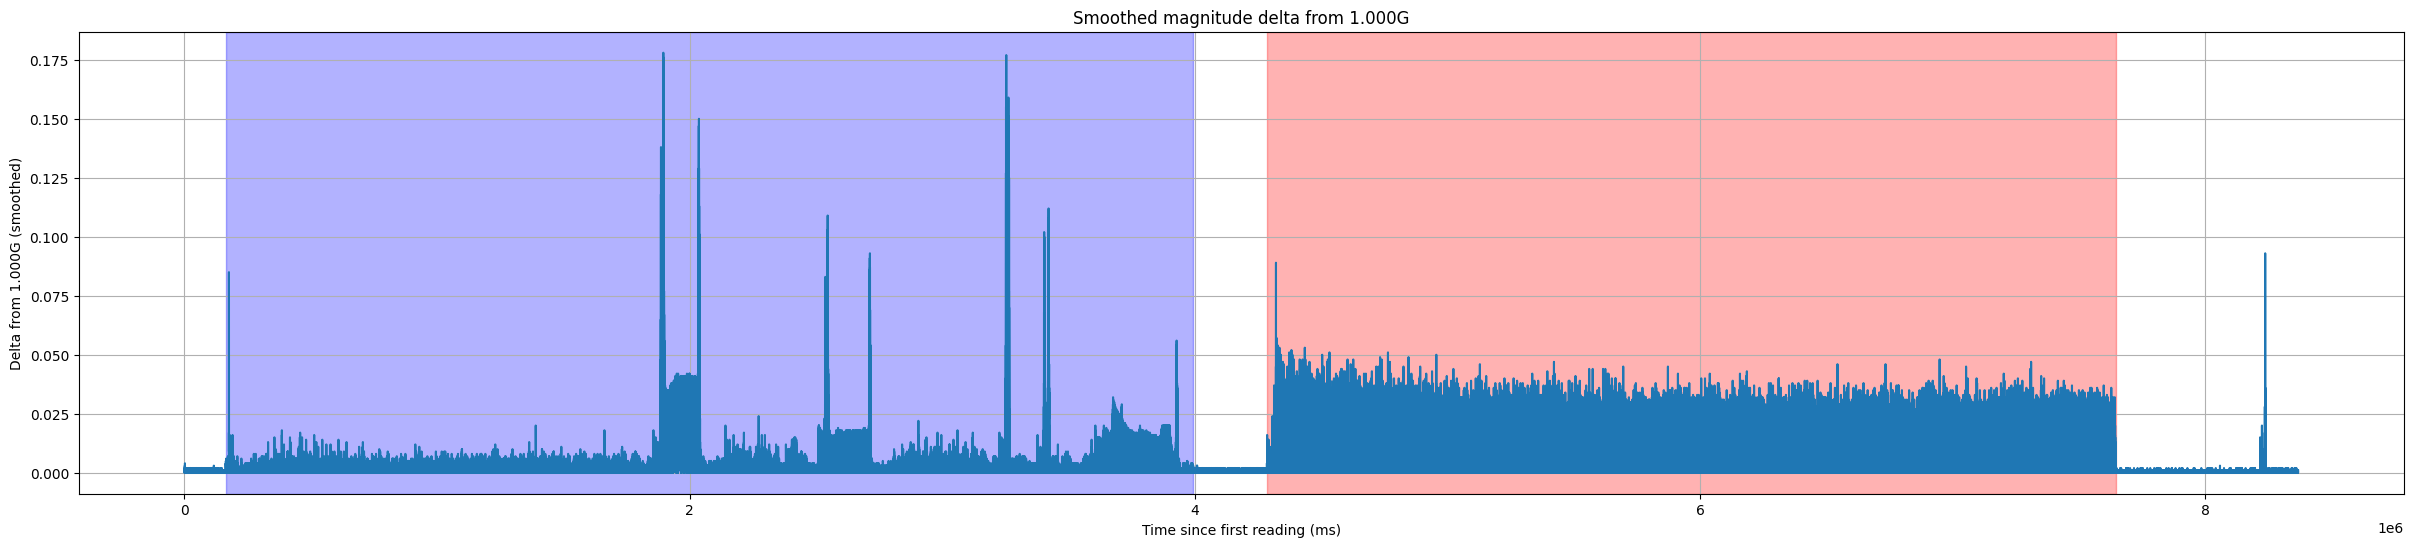

In [144]:
# apply rolling window smoothing
window_size = 10000

readings['magnitude_delta_smoothed'] = readings['magnitude_delta']

readings.fillna({"magnitude_delta_smoothed": 0.000}, inplace=True)

plot(readings['magnitude_delta_smoothed'], readings['timeStampMs'], "Smoothed magnitude delta from 1.000G", "Time since first reading (ms)", "Delta from 1.000G (smoothed)")

In [145]:
idle_threshold = readings[readings['actual_state'] == "IDLE"]['magnitude_delta_smoothed'].quantile(.8)
idle_threshold 

np.float64(0.0009999999999998899)

In [146]:
active_under_threshold = 1-(len(readings[(readings['actual_state'] == "ACTIVE") & (readings['magnitude_delta_smoothed'] > idle_threshold)]) / len(readings[readings['actual_state'] == "ACTIVE"]))
active_under_threshold

0.2650185114055865

In [147]:
readings['heuristic_state'] = np.where(readings['magnitude_delta_smoothed'] > idle_threshold, "ACTIVE", "IDLE")
readings.head()

,timeStampMs,x,y,z,actual_state,x_adjusted,z_adjusted,y_adjusted,magnitude_adjusted,magnitude_delta,magnitude_delta_smoothed,heuristic_state
2,19,0.013,-1.020,0.009,IDLE,0.001,-0.006,-1.001,1.001,0.001,0.001,IDLE
3,29,0.013,-1.020,0.009,IDLE,0.001,-0.006,-1.001,1.001,0.001,0.001,IDLE
4,38,0.013,-1.021,0.010,IDLE,0.001,-0.005,-1.002,1.002,0.002,0.002,ACTIVE
5,48,0.012,-1.021,0.010,IDLE,0.000,-0.005,-1.002,1.002,0.002,0.002,ACTIVE
6,57,0.012,-1.020,0.010,IDLE,0.000,-0.005,-1.001,1.001,0.001,0.001,IDLE


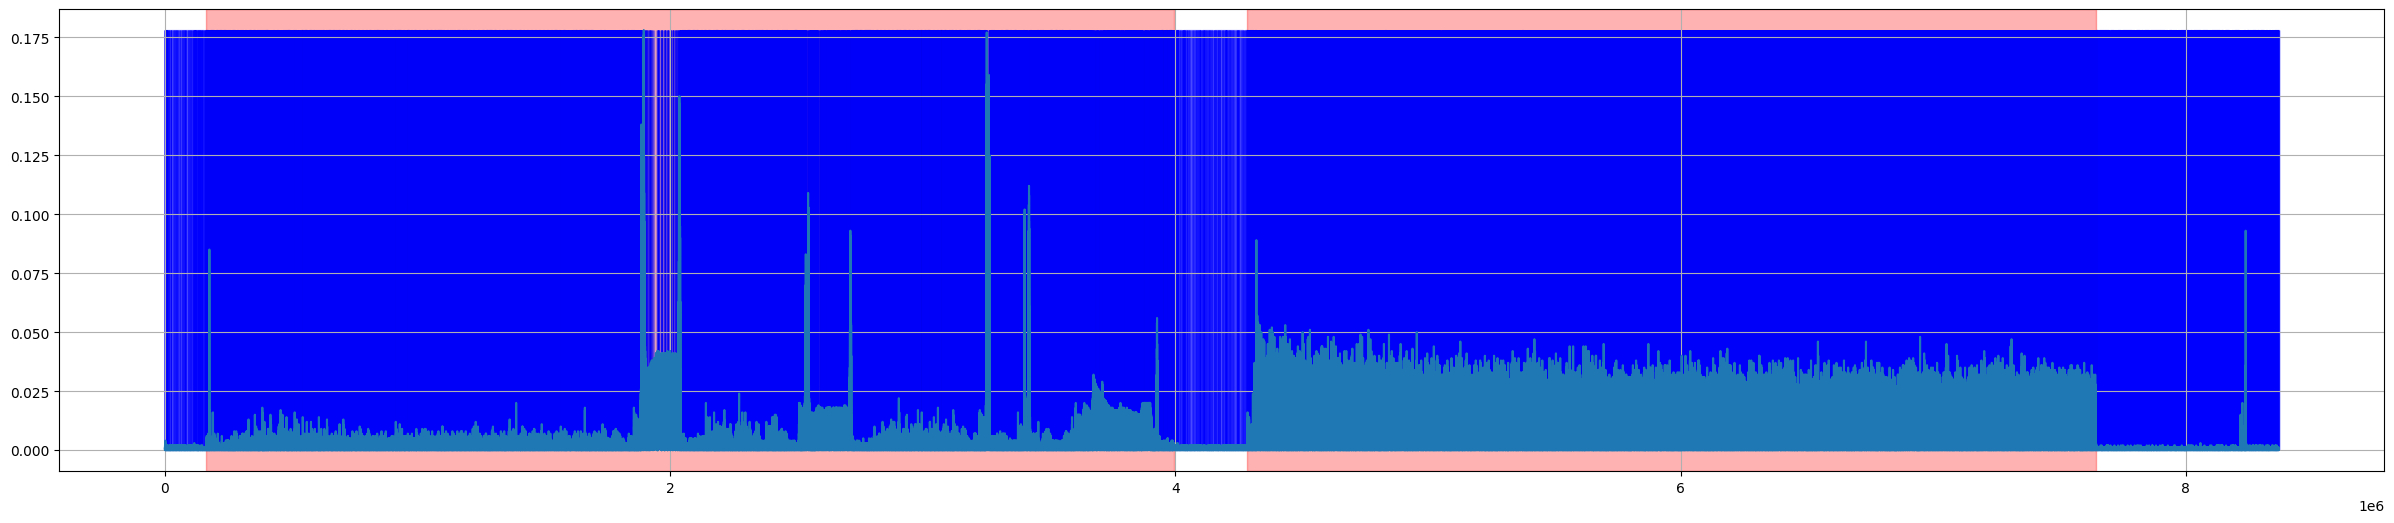

In [148]:
plt.figure(figsize=(30, 6))
plt.plot(readings['timeStampMs'], readings['magnitude_delta_smoothed'])

# highlight regions based on state
plt.axvspan(idle_region_timestamps[0][1], idle_region_timestamps[1][0], color='red', alpha=0.3, label="ACTIVE")
plt.axvspan(idle_region_timestamps[1][1], idle_region_timestamps[2][0], color='red', alpha=0.3, label="ACTIVE")

# highlight classified inactivity
plt.fill_between(readings['timeStampMs'], 0, max(readings['magnitude_delta_smoothed']), readings['heuristic_state'] == "IDLE", color="blue", alpha=0.2)

plt.grid(True)
plt.show()

In [149]:
# compute metrics
labels = ['IDLE', 'ACTIVE']

conf_matrix = confusion_matrix(readings['actual_state'], readings['heuristic_state'], labels=labels)
report = classification_report(readings['actual_state'], readings['heuristic_state'], labels=labels)
f1 = f1_score(readings['actual_state'], readings['heuristic_state'], labels=labels, pos_label="ACTIVE")

In [150]:
def print_rates(conf_matrix):
  true_negatives = conf_matrix[0][0]
  true_positives = conf_matrix[1][1]
  false_positives = conf_matrix[0][1]
  false_negatives = conf_matrix[1][0]

  true_positive_rate = true_positives / (true_positives + false_negatives)
  true_negative_rate = true_negatives / (true_negatives + false_positives)
  false_positive_rate = false_positives / (false_positives + true_negatives)
  false_negative_rate = false_negatives / (false_negatives + true_positives)

  print(f"True Positive Rate : {true_positive_rate * 100:6.2f}%")
  print(f"True Negative Rate : {true_negative_rate * 100:6.2f}%")
  print(f"False Negative Rate: {false_negative_rate * 100:6.2f}%")
  print(f"False Positive Rate: {false_positive_rate * 100:6.2f}%")

In [151]:
# metrics for generic threshold
print_rates(conf_matrix)
print(report)
print(f1)

True Positive Rate :  73.50%
True Negative Rate :  90.59%
False Negative Rate:  26.50%
False Positive Rate:   9.41%
              precision    recall  f1-score   support

        IDLE       0.36      0.91      0.51    122738
      ACTIVE       0.98      0.73      0.84    749808

    accuracy                           0.76    872546
   macro avg       0.67      0.82      0.68    872546
weighted avg       0.89      0.76      0.79    872546

0.8397913226871433


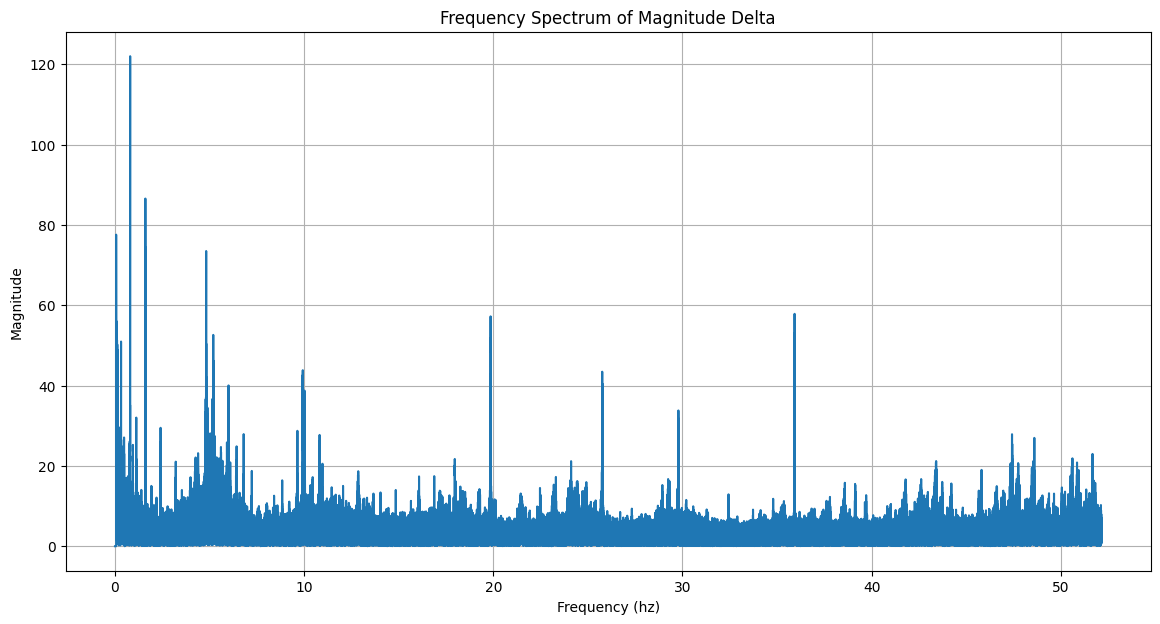

np.float64(0.0)

In [156]:
ms_per_sample = (readings['timeStampMs'].max() - readings['timeStampMs'].min()) / len(readings)
samples_per_second = 1000 / ms_per_sample

fft_values = np.fft.fft(readings[readings['actual_state'] == "ACTIVE"]['magnitude_delta'].values)
frequencies = np.fft.fftfreq(len(fft_values), d=1/samples_per_second)

# cutoff frequency, 1hz
cutoff_frequency = .0625

fft_values[np.abs(frequencies) < cutoff_frequency] = 0


fft_magnitude = np.abs(fft_values)

plt.figure(figsize=(14,7))
plt.plot(frequencies[:len(fft_values) // 2], fft_magnitude[:len(fft_values) // 2])
plt.title("Frequency Spectrum of Magnitude Delta")
plt.xlabel("Frequency (hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

fft_magnitude.min()

Band  4.1 -  5.1 Hz: Energy =  60021.943
Band  5.1 -  6.1 Hz: Energy =  58269.928
Band  0.1 -  1.1 Hz: Energy =  49765.190
Band  9.1 - 10.1 Hz: Energy =  34373.393
Band 47.1 - 48.1 Hz: Energy =  34077.647
Band 48.1 - 49.1 Hz: Energy =  32977.698
Band 10.1 - 11.1 Hz: Energy =  32629.503
Band  3.1 -  4.1 Hz: Energy =  31379.086
Band  6.1 -  7.1 Hz: Energy =  30367.728
Band 43.1 - 44.1 Hz: Energy =  30210.601


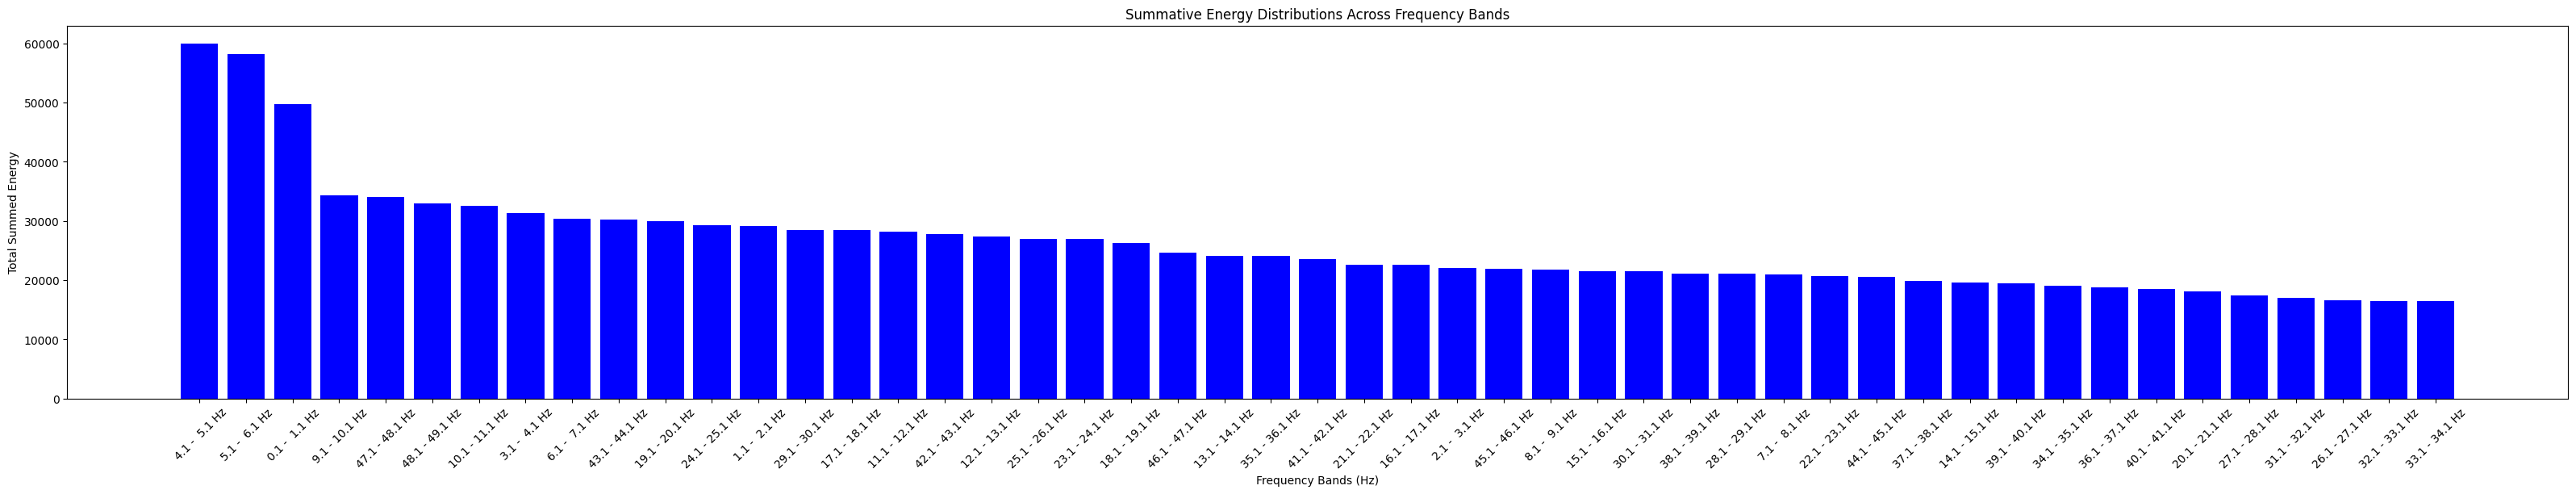

In [157]:
peak_threshold_value = 40

min_freq = 0.1
max_freq = 50
step_value = 1
steps = (max_freq - min_freq) / step_value

bands = []
current_freq = 0.1
for step in range(int(steps)):
  bands.append((current_freq, current_freq+step_value))
  current_freq += step_value

band_energies = []

for low, high in bands:
  band_energy = np.sum(fft_magnitude[(frequencies >= low) * (frequencies < high)])
  band_energies.append(((low, high), band_energy))

# normalize the band energy by the number of samples


# band_energies.sort(key=lambda x: x[1], reverse=True)

# for band, energy in band_energies:
#   print(f"Band {band[0]:4.1f} - {band[1]:4.1f} Hz: Energy = {energy:10.3f}")

# band_energies.sort(key=lambda x: x[1], reverse=True)[:10]
band_energies.sort(key=lambda x: x[1], reverse=True)
for band, energy in band_energies[:10]:
  print(f"Band {band[0]:4.1f} - {band[1]:4.1f} Hz: Energy = {energy:10.3f}")

band_labels = [f"{band[0]:4.1f} - {band[1]:4.1f} Hz" for band, _ in band_energies]
band_energies = [band_energy for _, band_energy in band_energies]

plt.figure(figsize=(40, 6))
plt.bar(band_labels, band_energies, color="blue")
plt.title("Summative Energy Distributions Across Frequency Bands")
plt.xlabel("Frequency Bands (Hz)")
plt.xticks(rotation=45)
plt.ylabel("Total Summed Energy")
plt.show()

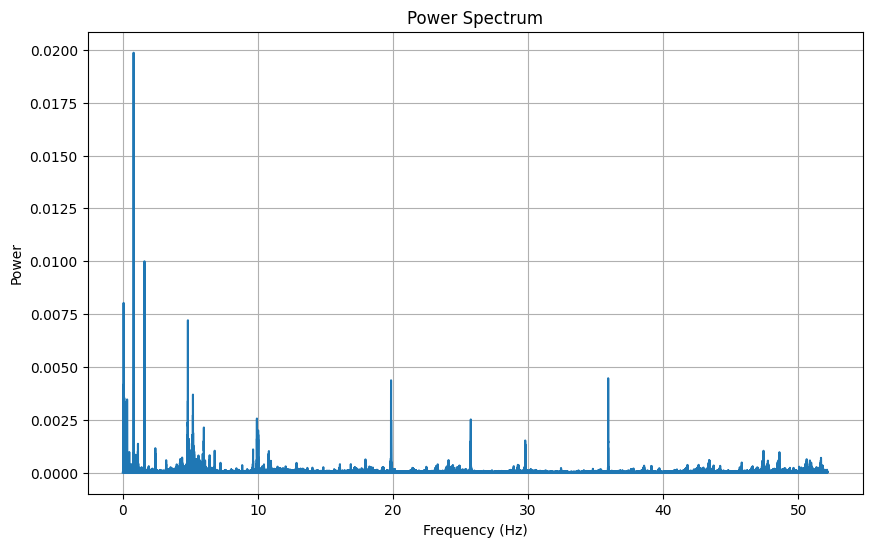

In [160]:
# Calculate FFT and power spectrum
signal = readings[readings['actual_state'] == "ACTIVE"]['magnitude_delta'].values

fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/samples_per_second)

fft_values[np.abs(frequencies) < cutoff_frequency] = 0
power_spectrum = np.abs(fft_values) ** 2 / len(signal)

# Plot the power spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies) // 2], power_spectrum[:len(power_spectrum) // 2])
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.show()

In [165]:
# find top few frequencies by power
freq_and_power = list(zip(frequencies, power_spectrum))
freq_and_power.sort(key=lambda x: x[1], reverse=True)

positive_half = freq_and_power[:len(freq_and_power) // 2]

plt.figure(figsize=(40, 6))
plt.bar([freq for freq, _ in positive_half], [power for _, power in positive_half], color="blue")
plt.title("Frequency Power - Sorted")
plt.xlabel("Frequency (Hz)")
plt.xticks(rotation=45)
plt.ylabel("Power")
plt.show()

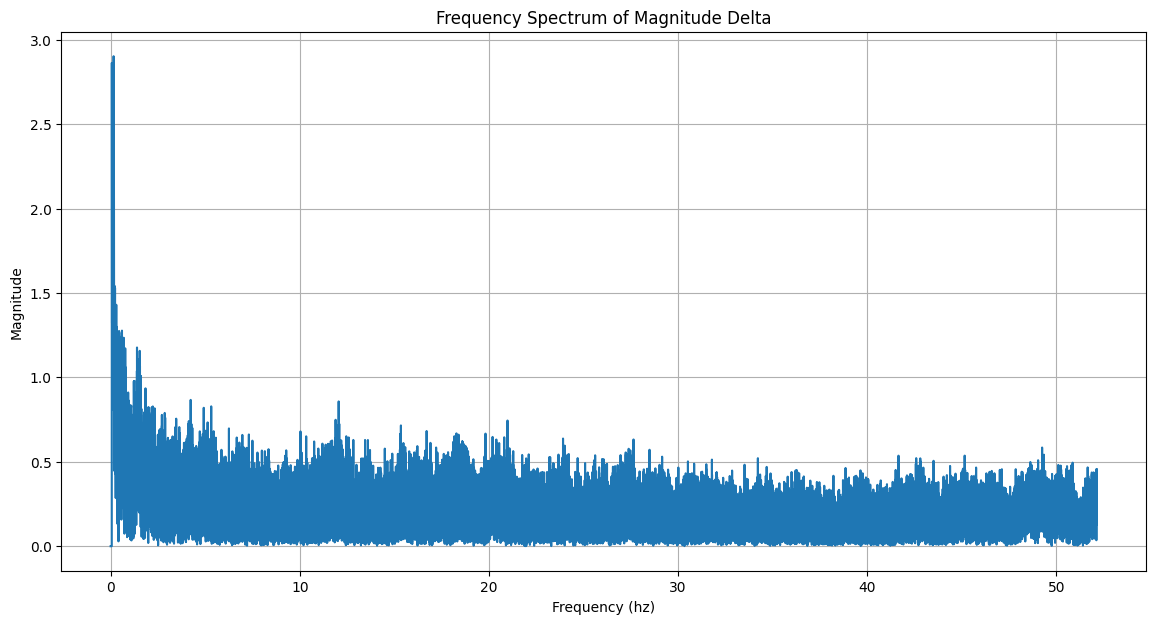

np.float64(0.2167550976339603)

In [154]:
ms_per_sample = (readings['timeStampMs'].max() - readings['timeStampMs'].min()) / len(readings)
samples_per_second = 1000 / ms_per_sample

fft_values = np.fft.fft(readings[readings['actual_state'] == "IDLE"]['magnitude_delta'].values)
frequencies = np.fft.fftfreq(len(fft_values), d=1/samples_per_second)

# cutoff frequency, 1hz
cutoff_frequency = .0625

fft_values[np.abs(frequencies) < cutoff_frequency] = 0


fft_magnitude = np.abs(fft_values)

plt.figure(figsize=(14,7))
plt.plot(frequencies[:len(fft_values) // 2], fft_magnitude[:len(fft_values) // 2])
plt.title("Frequency Spectrum of Magnitude Delta")
plt.xlabel("Frequency (hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

fft_magnitude.mean()



Band  0.1 -  1.1 Hz: Energy =    907.588
Band  1.1 -  2.1 Hz: Energy =    565.172
Band  2.1 -  3.1 Hz: Energy =    389.910
Band  4.1 -  5.1 Hz: Energy =    354.262
Band  3.1 -  4.1 Hz: Energy =    334.531
Band 18.1 - 19.1 Hz: Energy =    324.348
Band 20.1 - 21.1 Hz: Energy =    314.406
Band 11.1 - 12.1 Hz: Energy =    313.066
Band 15.1 - 16.1 Hz: Energy =    289.238
Band  5.1 -  6.1 Hz: Energy =    282.113


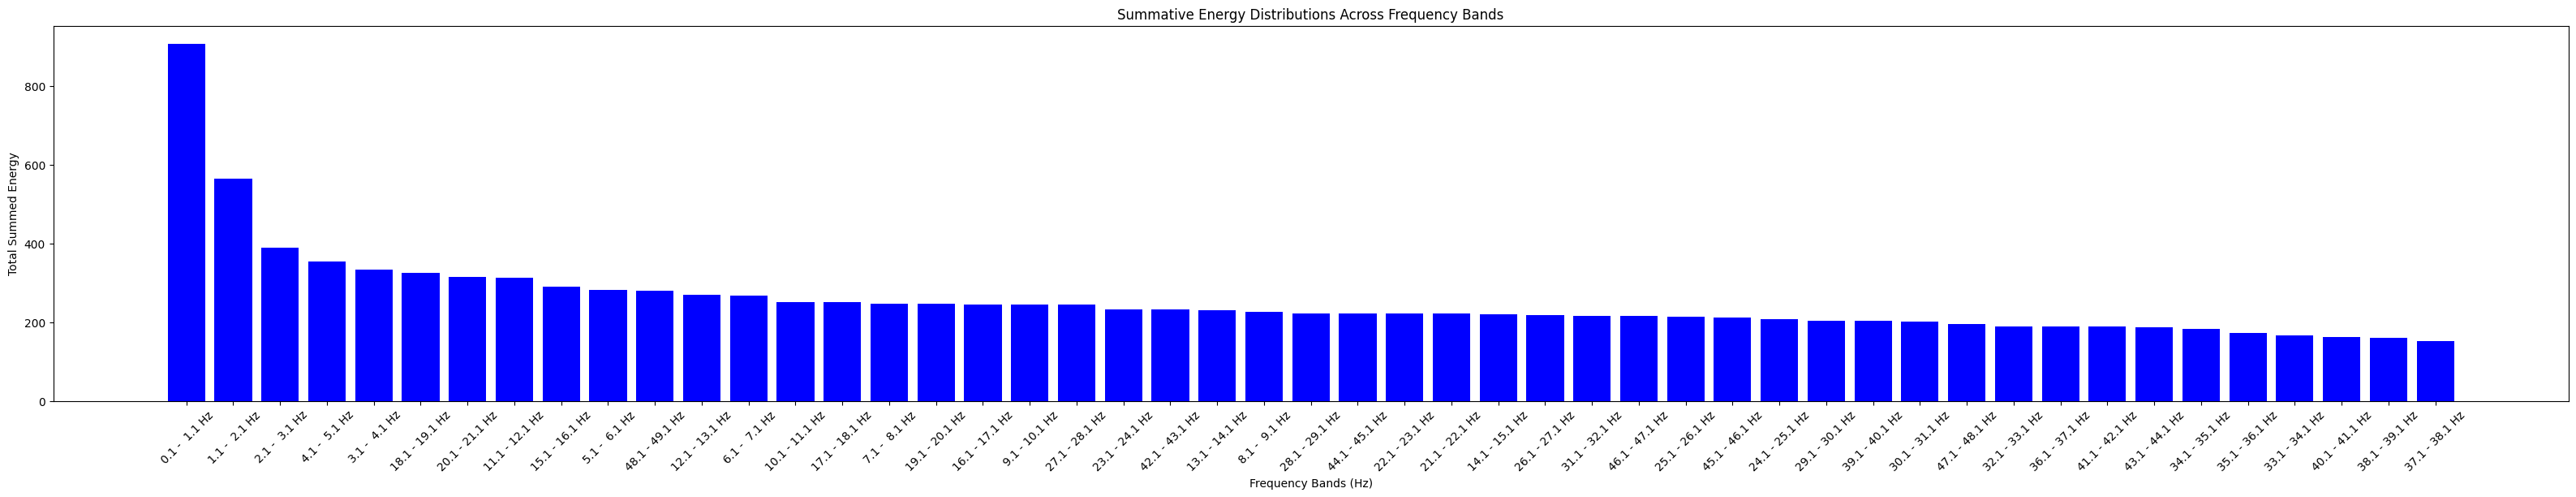

In [155]:
min_freq = 0.1
max_freq = 50
step_value = 1
steps = (max_freq - min_freq) / step_value

bands = []
current_freq = 0.1
for step in range(int(steps)):
  bands.append((current_freq, current_freq+step_value))
  current_freq += step_value

band_energies = []

for low, high in bands:
  band_energy = np.sum(fft_magnitude[(frequencies >= low) * (frequencies < high)])
  band_energies.append(((low, high), band_energy))

# normalize the band energy by the number of samples


# band_energies.sort(key=lambda x: x[1], reverse=True)

# for band, energy in band_energies:
#   print(f"Band {band[0]:4.1f} - {band[1]:4.1f} Hz: Energy = {energy:10.3f}")

# band_energies.sort(key=lambda x: x[1], reverse=True)[:10]
band_energies.sort(key=lambda x: x[1], reverse=True)
for band, energy in band_energies[:10]:
  print(f"Band {band[0]:4.1f} - {band[1]:4.1f} Hz: Energy = {energy:10.3f}")

band_labels = [f"{band[0]:4.1f} - {band[1]:4.1f} Hz" for band, _ in band_energies]
band_energies = [band_energy for _, band_energy in band_energies]

plt.figure(figsize=(40, 6))
plt.bar(band_labels, band_energies, color="blue")
plt.title("Summative Energy Distributions Across Frequency Bands")
plt.xlabel("Frequency Bands (Hz)")
plt.xticks(rotation=45)
plt.ylabel("Total Summed Energy")
plt.show()

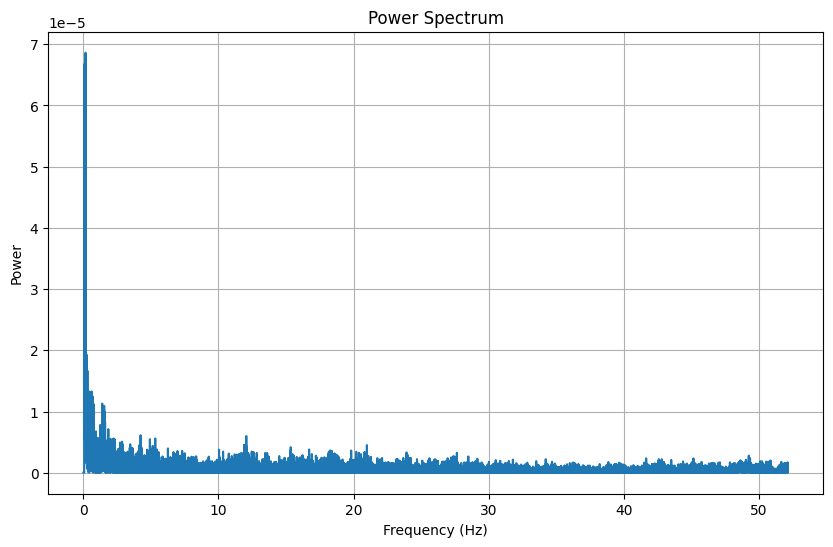

In [161]:
# Calculate FFT and power spectrum
signal = readings[readings['actual_state'] == "IDLE"]['magnitude_delta'].values

fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/samples_per_second)

fft_values[np.abs(frequencies) < cutoff_frequency] = 0
power_spectrum = np.abs(fft_values) ** 2 / len(signal)

# Plot the power spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies) // 2], power_spectrum[:len(power_spectrum) // 2])
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.show()